**DONT TOUCH THIS!**

In [ ]:
import random
import pickle

class LVQ:
  '''
  Class untuk membuat Learning Vector Quantization

  Attribute
  ---------
  X : list
    berupa array dua dimensi berisi fitur
  y : list
    berupa array satu dimensi berisi target
  w : list
    berupa array dua dimensi berisi weight untuk koneksi tiap neuron
  lr : float
    berupa float yang menunjukkan learning rate network
  epoch : int
    berupa integer yang menunjukkan epoch training
  '''
  def __init__(self):
    self.X = []
    self.y = []
    self.w = []
    self.lr = 0
    self.epoch = 0

  def load_data(self, X_test, y_test):
    '''
    Method untuk memuat data yang akan diproses

    Parameter
    ---------
    X_test : list
      list berisi fitur data
    y_test : list
      list berisi target data
    '''
    self.X = X_test
    self.y = y_test

  def init_weight(self, class_num, seed=random.randint(0,100), file_name='', random_weight=True):
    '''
    Method untuk menginisiasi weight network bisa dengan file atau acak

    Parameter
    ---------
    class_num : int
      menunjukkan jumlah class dari data
    seed : int, optional
      seed untuk pengacakan weight dari network (default acak)
    file_name : str, optional
      nama file weight dari network (default kosong)
    random_weight : bool, optional
      flag untuk memuat weight atau mengacak weight (default true)
    '''
    if random_weight:
      random.seed(seed)
      self.w = [[random.random() for _ in self.X[0]] for _ in range(class_num)]
    else:
      if file_name != '':
        file = open(file_name, 'rb')
        self.w = pickle.load(file)
        file.close()
      else:
        random.seed(seed)
        self.w = [self.X[random.randint(0, len(self.X))] for _ in range(class_num)]

  def save_weight(self, file_name):
    '''
    Method untuk menyimpan weight ke dalam bentuk binary dengan menggunakan pickle

    Parameter
    ---------
    file_name : str
      weight disimpan sebagai 'nama_file.bin'
    '''
    print('Weight saved as', file_name)
    file = open(file_name, 'wb')
    pickle.dump(self.w, file)
    file.close()

  def distance(self, a, b):
    '''
    Method untuk mencari jarak antara a dan b dengan menggunakan euclidean distance

    Parameter
    ---------
    a : list
      titik a dengan beberapa komponen dimensi
    b : list
      titik b dengan beberapa komponen dimensi

    Return
    ------
    dist : float
      hasil perhitungan jarak antara titik a dan b
    '''
    total = 0
    for a_, b_ in zip(a, b):
      total += (a_ - b_) ** 2
    dist = total ** 0.5
    return dist

  def compare(self, x):
    '''
    Method untuk membandingkan titik dengan weight untuk assign cluster

    Parameter
    ---------
    x : list
      titik dengan beberapa komponen dimensi
    
    Return
    ------
    cluster : int
      cluster tempat titik berada
    '''
    dist = []
    for w_ in self.w:
      dist.append(self.distance(x, w_))
    return dist.index(min(dist))

  def iterate(self):
    '''
    Method untuk melakukan satu kali iterasi

    Return
    ------
    confusion : list [TP, FP, FN, TN]
      confusion matrix untuk iterasi tersebut
    '''
    confusion = [1, 1, 1, 1]

    for x_, y_ in zip(self.X, self.y):
      cluster = self.compare(x_)
      if cluster == y_:
        if cluster == 0:
          confusion[0] += 1
        if cluster == 1:
          confusion[3] += 1
        for i in range(len(self.w[cluster])):
          self.w[cluster][i] = self.w[cluster][i] + self.lr*(x_[i] - self.w[cluster][i])
          
      elif cluster != y_:
        if cluster == 0:
          confusion[2] += 1
        if cluster == 1:
          confusion[1] += 1
        for i in range(len(self.w[cluster])):
          self.w[cluster][i] = self.w[cluster][i] - self.lr*(x_[i] - self.w[cluster][i])
    return confusion

  def score(self, conf):
    '''
    Method untuk menghitung berbagai score berdasar confusion matrix

    Parameter
    ---------
    conf : list
      confusion matrix
    
    Return
    ------
    accuracy : float
      merupakan nilai akurasi pada epoch tersebut
    recall : float
      merupakan nilai recall pada epoch tersebut
    precision : float
      merupakan nilai presisi pada epoch tersebut
    fpr : float
      merupakan nilai false positive rate pada epoch tersebut
    f1 : float
      merupakan nilai f1 pada epoch tersebut
    '''
    accuracy = (conf[0]+conf[3]) / (conf[0]+conf[1]+conf[2]+conf[3])
    recall = conf[3] / (conf[3]+conf[2])
    precision = conf[3] / (conf[3]+conf[1])
    fpr = conf[2] / (conf[0]+conf[2])
    f1 = 2*(precision*recall)/(precision+recall)

    return accuracy, recall, precision, fpr, f1

  def train(self, lr, epoch, verbose=False):
    '''
    Method untuk melakukan training network sesuai dengan learning rate dan epoch

    Parameter
    ---------
    lr : float
      learning rate untuk training
    epoch : int
      jumlah epoch untuk training
    verbose : bool, optional
      flag untuk menampilkan log metrics tiap epoch

    Return
    ------
    metrics : dictionary
      berisi metrics selama training dan bisa dilakukan plotting
    '''
    self.lr = lr
    self.epoch = epoch
    metrics = {
      'accuracy': [],
      'recall': [],
      'precision': [],
      'fpr': [],
      'f1': []
    }
    for i in range(self.epoch):
      print('Epoch %d/%d' % (i+1, self.epoch))
      conf = self.iterate()
      
      accuracy, recall, precision, fpr, f1 = self.score(conf)
      metrics['accuracy'].append(accuracy)
      metrics['recall'].append(recall)
      metrics['precision'].append(precision)
      metrics['fpr'].append(fpr)
      metrics['f1'].append(f1)

      if verbose:
        print('Accuracy:', accuracy)
        print('Recall:', recall)
        print('Precision:', precision)
        print('FPR:', fpr)
        print('F1:', f1)
      print('')
    return metrics
  
  def test(self, X_test, y_test):
    '''
    Method untuk melakukan testing network dengan data yang diberikan

    Paramter
    --------
    X_test : list
      list berisi fitur data
    y_test : list
      list berisi target data
    '''
    confusion = [1, 1, 1, 1]
    print('TESTING')
    for x_, y_ in zip(X_test, y_test):
      cluster = self.compare(x_)
      if cluster == y_:
        if cluster == 0:
          confusion[0] += 1
        if cluster == 1:
          confusion[3] += 1
      elif cluster != y_:
        if cluster == 0:
          confusion[2] += 1
        if cluster == 1:
          confusion[1] += 1

    accuracy, recall, precision, fpr, f1 = self.score(confusion)
    print('Accuracy:', accuracy)
    print('Recall:', recall)
    print('Precision:', precision)
    print('FPR:', fpr)
    print('F1:', f1)
  
  def predict(self, x):
    '''
    Method untuk melakukan prediksi berdasar data yang diberikan

    Parameter
    ---------
    x : list
      list berisi fitur data

    Return
    ------
    prediction : int
      prediksi class data
    '''
    prediction = []
    for x_ in x:
      cluster = self.compare(x_)
      prediction.append(cluster)
    return prediction

**MAIN CODE**

Import Packages

In [ ]:
import time
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

Initialization

In [ ]:
file_name = 'https://raw.githubusercontent.com/bpradana/tubes-ai/main/heart.csv'
lr = 0.000007
epoch = 12000
seed = 42
pca_components = 3
train_test_ratio = 0.2
class_num = 2

Read CSV

In [ ]:
df = pd.read_csv(file_name)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Data Exploration**

Correlation Matrix

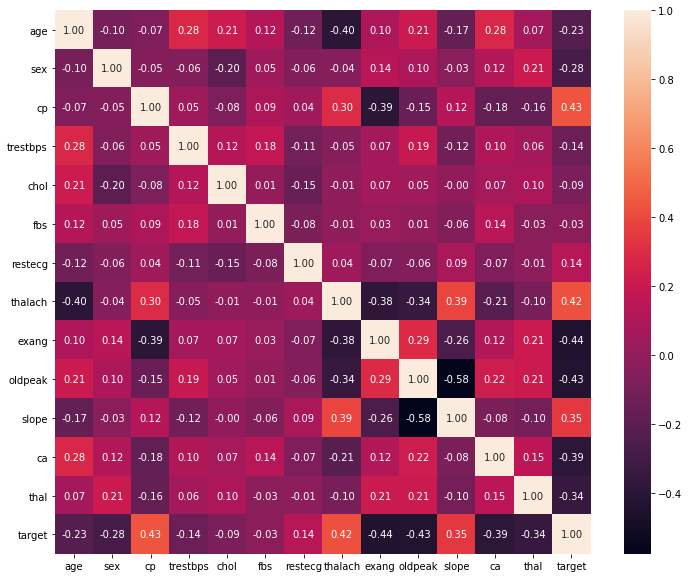

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,fmt='.2f')

**Data Preprocessing**

Categorical

In [ ]:
a = pd.get_dummies(df['cp'], prefix = "cp")
b = pd.get_dummies(df['thal'], prefix = "thal")
c = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, a, b, c]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])

df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,target,cp_0,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,1,0,0,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,1,0,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1.4,0,1,0,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0.8,0,1,0,1,0,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0.6,0,1,1,0,0,0,0,0,1,0,0,0,1


beta (coba coba)

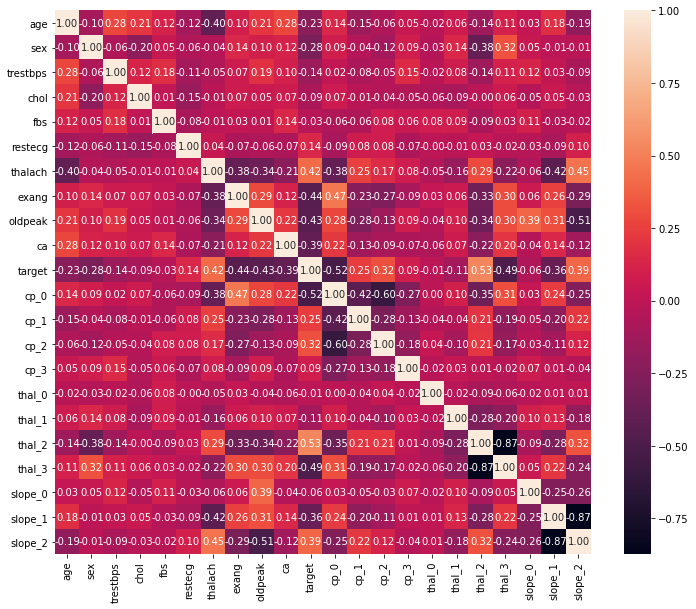

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,fmt='.2f')

Get Target

In [ ]:
y = df.target.values
x = df.drop(['target'], axis = 1)

Normalization

In [ ]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

Dimensionality Reduction

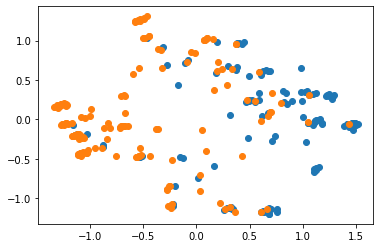

In [ ]:
pca = PCA(n_components=pca_components)
x = pca.fit_transform(x)
for i in range(class_num):
  d = x[np.where(y == i)]
  plt.scatter(d[:,0],d[:,1])

Split Data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = train_test_ratio, random_state=12)
x_train = np.array(x_train)
x_test = np.array(x_test)

**Machine Learning Stuff**

Training

In [ ]:
lvq = LVQ()
lvq.load_data(x_train, y_train)
lvq.init_weight(2, seed=seed, random_weight=False)
start_time = time.time()
metrics = lvq.train(lr, epoch, verbose=True)
print("\n--- %s seconds ---" % (time.time() - start_time))

Streaming output truncated to the last 5000 lines.
Epoch 11287/12000
Accuracy: 0.8170731707317073
Recall: 0.8248175182481752
Precision: 0.8432835820895522
FPR: 0.21428571428571427
F1: 0.8339483394833948

Epoch 11288/12000
Accuracy: 0.8170731707317073
Recall: 0.8248175182481752
Precision: 0.8432835820895522
FPR: 0.21428571428571427
F1: 0.8339483394833948

Epoch 11289/12000
Accuracy: 0.8170731707317073
Recall: 0.8248175182481752
Precision: 0.8432835820895522
FPR: 0.21428571428571427
F1: 0.8339483394833948

Epoch 11290/12000
Accuracy: 0.8170731707317073
Recall: 0.8248175182481752
Precision: 0.8432835820895522
FPR: 0.21428571428571427
F1: 0.8339483394833948

Epoch 11291/12000
Accuracy: 0.8170731707317073
Recall: 0.8248175182481752
Precision: 0.8432835820895522
FPR: 0.21428571428571427
F1: 0.8339483394833948

Epoch 11292/12000
Accuracy: 0.8170731707317073
Recall: 0.8248175182481752
Precision: 0.8432835820895522
FPR: 0.21428571428571427
F1: 0.8339483394833948

Epoch 11293/12000
Accuracy: 0.8

Testing

In [ ]:
lvq.test(x_test, y_test)

TESTING
Accuracy: 0.8153846153846154
Recall: 0.84375
Precision: 0.7941176470588235
FPR: 0.16129032258064516
F1: 0.8181818181818182


Save Weight

In [ ]:
lvq.save_weight('weight.bin')

Weight saved as weight.bin


Plot

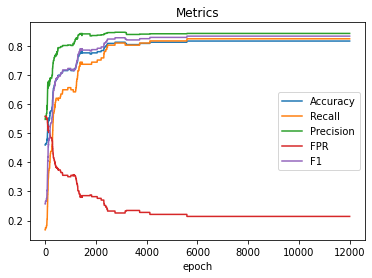

In [ ]:
plt.plot(metrics['accuracy'])
plt.plot(metrics['recall'])
plt.plot(metrics['precision'])
plt.plot(metrics['fpr'])
plt.plot(metrics['f1'])

plt.title('Metrics')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Recall', 'Precision', 'FPR', 'F1'])

plt.show()